# Atlas Processing (Cortical Parcellations - Destrieux)

- Documentation: https://nilearn.github.io/auto_examples/01_plotting/plot_surf_atlas.html
- Note: nilearn's 'surface.load_surface_data' function does not suppport .mgh / .mgz files; must use mri_convert or mris_convert (part of Freesurfer) to first convert to an acceptable format, e.g. .nii

In [1]:
import nilearn
from nilearn import surface
from nilearn import plotting

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import png  # for reloading / working with previously saved images

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Load data into df

In [72]:
# data directory
# overall format:
# -- hbn_dir/sub-{EID}/label_subdir/parc_filename

hbn_dir = '/scratch/users/samjohns/HBN/BIDS_curated/derivatives/freesurfer'
label_subdir = '/label'
surf_subdir = '/surf'

curv_filename = 'lh.curv'
infl_filename = 'lh.inflated'
pial_filename = 'lh.pial'
parc_filename = 'lh.aparc.a2009s.annot'

In [3]:
fsa = nilearn.datasets.fetch_surf_fsaverage('fsaverage')
fsa_il = surface.load_surf_mesh(fsa.infl_left)
fsa_sl = surface.load_surf_mesh(fsa.sphere_left)

In [4]:
subjects = [s for s in os.listdir(hbn_dir) if 'sub-' in s]

In [5]:
subjects.sort()

In [6]:
test_sub = subjects[0]

In [7]:
test_parc_path = f'{hbn_dir}/{test_sub}{label_subdir}/{parc_filename}'

In [8]:
# check file exists
os.path.exists(test_parc_path)

True

In [47]:
destrieux_atlas = nilearn.datasets.fetch_atlas_surf_destrieux()


Dataset created in /home/users/samjohns/nilearn_data/destrieux_surface



 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


In [148]:
destrieux_official_labels = list(zip(range(len(destrieux_atlas.labels)), destrieux_atlas.labels))

In [74]:
test_parc = surface.load_surf_data(test_parc_path)
test_curv = surface.load_surf_data(f'{hbn_dir}/{test_sub}{surf_subdir}/{curv_filename}')

In [75]:
test_pial = surface.load_surf_mesh(f'{hbn_dir}/{test_sub}{surf_subdir}/{pial_filename}')
test_infl = surface.load_surf_mesh(f'{hbn_dir}/{test_sub}{surf_subdir}/{infl_filename}')

In [146]:
# important:
# select a subset of labels that are visible in  ventral view

# add 43 if required
labels_to_plot = [2, 19, 21, 23, 24, 25, 30, 37, 38, 50, 51, 57, 58, 59, 60, 61, 63, 65]
selected_parc = np.array([labels_to_plot.index(l) if l in labels_to_plot else -1 for l in test_parc])
len(labels_to_plot)

18

In [132]:
lo = 54
inc = 18
hi = lo + inc

filtered_parc = np.array([l if (l > lo - 1) and (l < hi)  else lo - 1 for l in test_parc])

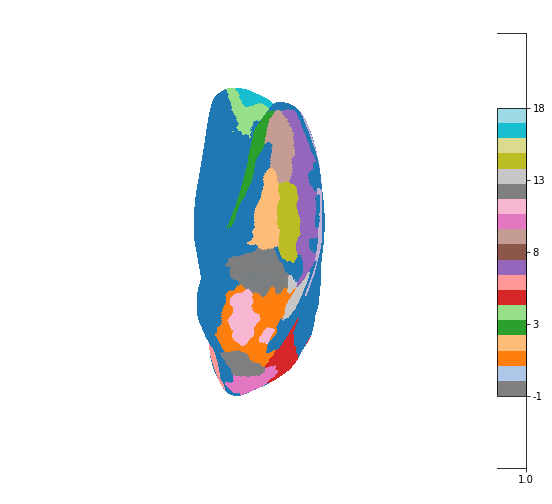

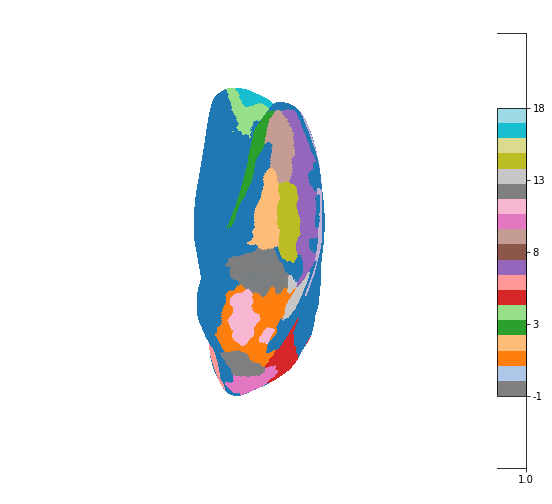

In [145]:
fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_surf_roi(test_infl, selected_parc,
                       view=(210, 90),
                       # bg_map=test_curv,
                       # bg_on_data=True, 
                       figure=fig,
                       cmap='tab20',
                       colorbar=True
                      )

In [184]:
ind = 2
eid = bottom_df['EID'].unique()[ind]
bg = list(bottom_df[bottom_df.EID == eid]['AnatObject'])[0]
ms = list(bottom_df[bottom_df.EID == eid]['LabelMask'])
ls = list(bottom_df[bottom_df.EID == eid]['LabelObject'])

In [185]:
def combine_masks(masks, indices=None):

    assert isinstance(masks, list)
    if indices is None:
        indices = list(range(1, len(masks) + 1))
    
    # find largest mask and place on background
    l = [m.sum() for m in masks]
    maxl = max(l)
    indmax = l.index(maxl)
    bg = masks[indmax]
    
    o_masks = masks[:]
    o_masks[0], o_masks[indmax] = o_masks[indmax], o_masks[0]
    
    comb = np.zeros_like(o_masks[0]) 
    for i, m in zip(indices, o_masks):
        inds = list(m.nonzero()[0])
        comb[inds] = i
    return comb

In [186]:
cm = combine_masks(ms)

In [26]:
view = plotting.view_surf(test_pial,
                          test_parc,
                          threshold=0.1,
                          cmap='tab20',
                          colorbar=True
                         )

In [30]:
test_sub

'sub-NDARAA075AMK'

In [28]:
view_infl = plotting.view_surf(test_infl,
                          test_parc,
                          threshold=0.1,
                          cmap='tab20',
                          colorbar=True,
                         )

In [31]:
view_infl.save_as_html(f'destrieux-inflated-{test_sub}.html')

In [32]:
view.save_as_html(f'destrieux-pial-{test_sub}.html')

In [195]:
view.save_as_html('view.html')

# save images for bottom eids

In [153]:
bottom_eids = bottom_df['EID'].unique()

In [154]:
output_dir = './images/label-images'
os.makedirs(output_dir, exist_ok=True)

In [155]:
def view_subject(df, eid, save=True, fig=None):
    """Note: if output_file is specified, figure will be saved with that title."""
    bg = list(df[df.EID == eid]['AnatObject'])[0]  # required to take 1 elt since this contains repeats of AnatObject
    ms = list(df[df.EID == eid]['LabelMask'])
    ls = list(df[df.EID == eid]['LabelObject'])
    cm = combine_masks(ms)
    if save == True:
        save_name = f'{output_dir}/{eid}-ots-labels.png'
    else:
        save_name = None
    plotting.plot_surf_roi(fsa_il, cm, bg_map=bg,
                       view=(210, 90), 
                       # bg_on_data=True, 
                       figure=fig, 
                       threshold=0.1,
                       cmap='Pastel2',
                       output_file=save_name)
    return fig

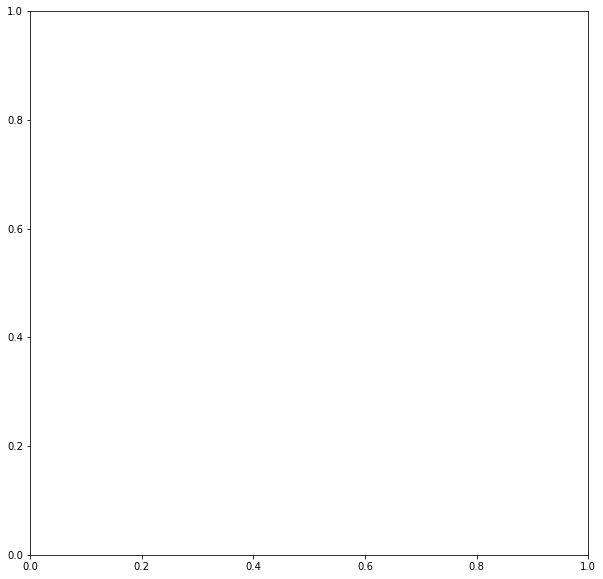

In [156]:
fig, ax = plt.subplots(figsize=(10,10))

In [157]:
for e in bottom_eids:
    view_subject(bottom_df, e, fig=fig)

KeyboardInterrupt: 

In [21]:
top_eids = top_df['EID'].unique()

In [22]:
len(bottom_eids), len(top_eids)

(20, 22)

In [23]:
for e in top_eids[-4:]:
    view_subject(top_df, e, fig=fig)

In [22]:
view = plotting.view_surf(fsa_il, cm, bg_map=bg,
                   # bg_on_data=True,
                   cmap='Pastel2', threshold=0.01)

In [151]:
view

NameError: name 'view' is not defined

In [152]:
plotting.plot_surf_roi(fsa_il, cm, bg_map=bg,
                       view=(210, 90), 
                       # bg_on_data=True, 
                       figure=fig, 
                       threshold=0.1,
                       cmap='Pastel2',
                       output_file=f'{output_dir}/{eid}-ots-labels.png')

NameError: name 'cm' is not defined

## calculate x and y OTS gaps

In [ ]:
# gaps


In [ ]:
# automatic gap detection based on OTS label (x- break and y-break)


In [28]:
labels = list(bottom_df[['EID', 'LabelObject']].sort_values('EID')

,EID,LabelObject
26,NDARDC704GKW,"[161860, 40301, 161859, 90503, 40299, 90510, 1..."
27,NDARDC704GKW,"[46401, 1388, 46399, 46403, 46400, 15681, 4640..."
23,NDARDC704GKW,"[75493, 7969, 75491, 75495, 75492, 34244, 7549..."
8,NDARDM118LR6,"[101982, 15696, 101980, 101981, 15697, 46417, ..."
1,NDARDM118LR6,"[114400, 22596, 114399, 114402, 90822, 10064, ..."
28,NDAREC480KFA,"[90816, 10063, 90814, 90818, 90815, 40424, 908..."
25,NDAREC480KFA,"[97662, 13296, 97660, 97661, 13297, 44017, 976..."
24,NDAREC480KFA,"[127879, 13259, 97593, 62815, 28474, 62817, 12..."
5,NDARFN452VPC,"[79778, 148969, 35996, 79777, 35995, 79779, 14..."
19,NDARFN452VPC,"[128037, 13297, 97661, 62928, 28542, 62930, 12..."


In [31]:
labels = bottom_df[bottom_df.EID == bottom_eids[0]]['LabelObject']

In [52]:
label_xyz = fsa_il.coordinates[labels[0]]

In [56]:
# axis 0 -- vertex # 
# axis 1 -- (x, y, z)

fsa_il.coordinates.shape

(163842, 3)

In [57]:
# length of anterior-posterior (y) gap of posterior interruption

In [58]:
label_y = label_xyz[:,1]  # y is the second coordinate

In [67]:
delta_x, delta_y, _ = label_xyz.max(axis=0) - label_xyz.min(axis=0)

In [148]:
def get_delta(label, coord=1):
    label_xyz = fsa_il.coordinates[label]
    delta_x, delta_y, delta_z = label_xyz.max(axis=0) - label_xyz.min(axis=0)
    if coord == 2:
        return delta_z
    elif coord == 0:
        return delta_x
    else:
        return delta_y

In [198]:
df['DeltaY'] = df['LabelObject'].apply(get_delta)

In [199]:
df['DeltaX'] = df['LabelObject'].apply(lambda row: get_delta(row, coord=0))

In [200]:
df

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,8.603447,5.663795
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,13.646151,19.776184
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.677368,20.270681
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,5.861015,9.326008
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0,115.347984,32.356796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NDARRZ993EL4,sub-NDARRZ993EL4.fsa.lh.curv.nii,L_ots_sub-NDARRZ993EL4.label,"[101958, 137167, 15684, 101957, 7106, 101959, ...","[-0.17966372, -0.31112504, -0.08123495, 0.1773...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,False,True,1,108.583656,44.816128
102,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_ots_sub-NDARKT714TXR.label,"[56000, 118336, 24385, 55999, 10987, 56001, 11...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,101.468826,27.457767
103,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg2_sub-NDARKT714TXR.label,"[97628, 13278, 97627, 62869, 5598, 162089, 162...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,28.987160,17.343281
104,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg1_sub-NDARKT714TXR.label,"[114399, 22596, 53315, 114400, 114398, 22595, ...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,10.072916,17.430279


In [ ]:
# calculate maxes and 

In [ ]:
# - Difference between groups
# - maxes of label2

In [69]:
gap_numbers_raw = [[1,0,1],
                   [0,1,0],
                   [0,1,0],
                   [1,0,1],
                   [1,0,0],
                   [1,0,0],
                   [0,1,1],
                   [0,1,1],
                   [1,1,0],
                   [0,0,1],
                   [0,1,0],  # coded as 2, but unclear
                   [0,1,0],
                   [1,1,0],
                   [0,1,0],
                   [0,0,0],
                   [1,0,0],  # coded as 1, but unclear
                   [1,0,0],
                   [0,0,1],
                   [1,1,0],
                   [0,1,1],  # coded as 2, but unclear
                   [0,1,1],
                   [0,0,0],  # problem with image generation
                   [0,1,1],
                   [0,0,0],  # problem with image generation
                   [0,0,1],
                   [1,1,0],
                   [1,1,0],  # coded as 1 and 2, but unclear: could be 2 and 3
                   [1,0,1],
                   [1,1,0],
                   [1,1,0],
                   [0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [1,1,0],
                   [1,0,0],
                   [1,0,1],
                   [1,0,1],
                   [0,1,1],
                   [0,1,1],
                   [1,0,1],
                   [1,1,0],
                   [1,1,0]  # coded as 1, 2 but unclear
                  ]

In [70]:
gn = np.array(gap_numbers_raw)

In [71]:
gn.shape

(42, 3)

In [76]:
df = pd.concat([bottom_df, top_df])

In [83]:
eids = list(df.sort_values('EID')['EID'].unique())

In [104]:
eids.sort()

In [106]:
gap1 = gn[:,0]
gap2 = gn[:,1]
gap3 = gn[:,2]

# check
len(gap1) == len(gap2) == len(gap3) == len(eids)

True

In [107]:
gap_df = pd.DataFrame({'EID': eids, 'Gap1': gap1, 'Gap2': gap2, 'Gap3': gap3})

In [96]:
df_nogap = df.copy()

In [108]:
df = pd.merge(df_nogap, gap_df, on='EID', how='left')

In [117]:
df['Bottom'] = df['EID'].isin(bottom_eids)
df['Top'] = df['EID'].isin(top_eids)

In [121]:
df['PosteriorGap'] = df.apply(lambda row: row['Gap2'] | row['Gap3'], axis=1)

In [122]:
df.groupby('EID')

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NDARRZ993EL4,sub-NDARRZ993EL4.fsa.lh.curv.nii,L_ots_sub-NDARRZ993EL4.label,"[101958, 137167, 15684, 101957, 7106, 101959, ...","[-0.17966372, -0.31112504, -0.08123495, 0.1773...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,False,True,1
102,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_ots_sub-NDARKT714TXR.label,"[56000, 118336, 24385, 55999, 10987, 56001, 11...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1
103,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg2_sub-NDARKT714TXR.label,"[97628, 13278, 97627, 62869, 5598, 162089, 162...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1
104,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg1_sub-NDARKT714TXR.label,"[114399, 22596, 53315, 114400, 114398, 22595, ...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1


In [127]:
len(bottom_eids), len(top_eids)

(20, 22)

In [138]:
df_post_gap = df.groupby('EID', as_index=False).mean()

In [145]:
df_post_gap[df_post_gap.Bottom==False].sum()

EID             NDARAJ977PRJNDARAN814UPRNDARAR305LXGNDARDE681U...
LabelClass                                                   18.5
Gap1                                                         10.0
Gap2                                                         12.0
Gap3                                                          9.0
Bottom                                                        0.0
Top                                                          22.0
PosteriorGap                                                 18.0
dtype: object

In [147]:
bottom_gaps = 15
top_gaps = 18

In [201]:
df.sort_values('EID')

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX
95,NDARAJ977PRJ,sub-NDARAJ977PRJ.fsa.lh.curv.nii,L_ots_sub-NDARAJ977PRJ.label,"[101979, 15696, 46415, 101980, 101978, 15695, ...","[-0.18500888, -0.12410367, -0.00010626869, -0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,False,True,1,109.115410,41.986382
91,NDARAJ977PRJ,sub-NDARAJ977PRJ.fsa.lh.curv.nii,L_otg1_sub-NDARAJ977PRJ.label,"[62915, 128017, 28534, 62914, 13292, 62916, 12...","[-0.18500888, -0.12410367, -0.00010626869, -0....",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,False,True,1,11.814541,13.070831
92,NDARAJ977PRJ,sub-NDARAJ977PRJ.fsa.lh.curv.nii,L_otg2_sub-NDARAJ977PRJ.label,"[53197, 114187, 22478, 53196, 22476, 53198, 11...","[-0.18500888, -0.12410367, -0.00010626869, -0....",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,False,True,1,16.907219,8.632066
88,NDARAN814UPR,sub-NDARAN814UPR.fsa.lh.curv.nii,L_ots_sub-NDARAN814UPR.label,"[161978, 40341, 90607, 161979, 161977, 34212, ...","[-0.08372178, -0.1287953, 0.15918742, 0.183637...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,False,True,1,100.075172,29.565048
90,NDARAN814UPR,sub-NDARAN814UPR.fsa.lh.curv.nii,L_otg2_sub-NDARAN814UPR.label,"[62879, 5601, 62877, 62881, 62878, 28512, 6288...","[-0.08372178, -0.1287953, 0.15918742, 0.183637...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,False,True,1,24.816189,12.346756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,NDARYZ637LK4,sub-NDARYZ637LK4.fsa.lh.curv.nii,L_ots_sub-NDARYZ637LK4.label,"[162331, 31962, 137220, 44020, 13300, 90902, 1...","[-0.051413614, -0.09352741, -0.04653005, 0.049...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,78.726624,24.510698
40,NDARYZ637LK4,sub-NDARYZ637LK4.fsa.lh.curv.nii,L_otg2_sub-NDARYZ637LK4.label,"[41696, 41698, 154, 10976, 41697, 143699, 1437...","[-0.051413614, -0.09352741, -0.04653005, 0.049...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,20.092125,15.999365
30,NDARZM580BG2,sub-NDARZM580BG2.fsa.lh.curv.nii,L_otg2_sub-NDARZM580BG2.label,"[162138, 40394, 162137, 162139, 162135, 10026,...","[-0.24244143, -0.09189085, -0.33669814, 0.1042...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,17.474602,17.416433
21,NDARZM580BG2,sub-NDARZM580BG2.fsa.lh.curv.nii,L_otg1_sub-NDARZM580BG2.label,"[114409, 22601, 114408, 90837, 10066, 162260, ...","[-0.24244143, -0.09189085, -0.33669814, 0.1042...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,6.027042,14.336589


# Load pheno data for further analysis

In [202]:
data_dir = '/Users/samjohns/Desktop/hbn-pheno'

# towre
dtr = pd.read_csv(data_dir+'/assessment_data/9994_TOWRE_20211026.csv')
dtr['towre_total_num'] = pd.to_numeric(dtr['TOWRE_Total_Scaled'], errors='coerce')

# wiat
dwt = pd.read_csv(data_dir+'/assessment_data/9994_WIAT_20211026.csv')
dwt['word_stnd_num'] = pd.to_numeric(dwt['WIAT_Word_Stnd'], errors='coerce') # errors='coerce' sets parsing errors to NaN

In [212]:
df_wiat = dwt[['EID', 'word_stnd_num']]
df_towre = dtr[['EID', 'towre_total_num']]

In [208]:
df_pheno = pd.merge(df, df_wiat, how='left', on='EID')

In [213]:
df_pheno = pd.merge(df_pheno, df_towre, how='left', on='EID')

In [215]:
df_pheno

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX,word_stnd_num,towre_total_num
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,8.603447,5.663795,80.0,71.0
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,13.646151,19.776184,67.0,58.0
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.677368,20.270681,76.0,NaN
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,5.861015,9.326008,76.0,NaN
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0,115.347984,32.356796,83.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,NDARRZ993EL4,sub-NDARRZ993EL4.fsa.lh.curv.nii,L_ots_sub-NDARRZ993EL4.label,"[101958, 137167, 15684, 101957, 7106, 101959, ...","[-0.17966372, -0.31112504, -0.08123495, 0.1773...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,False,True,1,108.583656,44.816128,117.0,104.0
105,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_ots_sub-NDARKT714TXR.label,"[56000, 118336, 24385, 55999, 10987, 56001, 11...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,101.468826,27.457767,120.0,117.0
106,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg2_sub-NDARKT714TXR.label,"[97628, 13278, 97627, 62869, 5598, 162089, 162...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,28.987160,17.343281,120.0,117.0
107,NDARKT714TXR,sub-NDARKT714TXR.fsa.lh.curv.nii,L_otg1_sub-NDARKT714TXR.label,"[114399, 22596, 53315, 114400, 114398, 22595, ...","[-0.006042588, -0.14591345, -0.28698874, -0.03...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,False,True,1,10.072916,17.430279,120.0,117.0


In [217]:
pd.set_option('display.max_rows', None)  # modify default pd option to display all rows of df

In [218]:
df_pheno

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX,word_stnd_num,towre_total_num
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,8.603447,5.663795,80.0,71.0
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,13.646151,19.776184,67.0,58.0
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.677368,20.270681,76.0,NaN
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,5.861015,9.326008,76.0,NaN
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0,115.347984,32.356796,83.0,83.0
5,NDARFN452VPC,sub-NDARFN452VPC.fsa.lh.curv.nii,L_otg3_sub-NDARFN452VPC.label,"[79778, 148969, 35996, 79777, 35995, 79779, 14...","[-0.07970364, 0.013842695, 0.066333696, 0.0836...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,True,False,1,6.304565,17.054226,70.0,63.0
6,NDARWX605LAD,sub-NDARWX605LAD.fsa.lh.curv.nii,L_otg1_sub-NDARWX605LAD.label,"[137221, 31961, 137219, 137220, 31962, 70134, ...","[-0.13107023, 0.13982707, -0.14221644, 0.15808...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,True,False,1,23.690857,14.497428,74.0,65.0
7,NDARWA102TY7,sub-NDARWA102TY7.fsa.lh.curv.nii,L_otg3_sub-NDARWA102TY7.label,"[161865, 40303, 161864, 114201, 10020, 161867,...","[-0.12469759, 0.09059597, -0.08698126, 0.16099...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,True,False,1,10.335190,9.570037,65.0,66.0
8,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_ots_sub-NDARDM118LR6.label,"[101982, 15696, 101980, 101981, 15697, 46417, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.568939,25.554396,67.0,58.0
9,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg1_sub-NDARUL341DD2.label,"[70134, 137222, 31963, 70133, 31961, 70135, 13...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,6.927695,11.247799,76.0,NaN


In [223]:
def correct_labels(row):
    correct_label = 1
    lc = row['LabelClass']
    g1 = row['Gap1']
    g2 = row['Gap2']
    g3 = row['Gap3']
    if lc == 0:
        correct_label = 0
    if lc == 3:
        if g3 == 0:
            correct_label = 2
        else:
            correct_label = 3
    if lc == 1:
        if g1 == 0:
            correct_label = 2
        else:
            correct_label = 1
    if lc == 2:
        if g2 == 0:
            if g1 == 0:
                correct_label = 3
            else:
                correct_label = 1
    return correct_label

In [227]:
df_pheno['LCCorr'] = df_pheno.apply(correct_labels, axis=1)

In [228]:
df_pheno

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX,word_stnd_num,towre_total_num,LCCorr
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,8.603447,5.663795,80.0,71.0,2
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,13.646151,19.776184,67.0,58.0,1
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.677368,20.270681,76.0,NaN,0
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,5.861015,9.326008,76.0,NaN,1
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0,115.347984,32.356796,83.0,83.0,0
5,NDARFN452VPC,sub-NDARFN452VPC.fsa.lh.curv.nii,L_otg3_sub-NDARFN452VPC.label,"[79778, 148969, 35996, 79777, 35995, 79779, 14...","[-0.07970364, 0.013842695, 0.066333696, 0.0836...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,True,False,1,6.304565,17.054226,70.0,63.0,2
6,NDARWX605LAD,sub-NDARWX605LAD.fsa.lh.curv.nii,L_otg1_sub-NDARWX605LAD.label,"[137221, 31961, 137219, 137220, 31962, 70134, ...","[-0.13107023, 0.13982707, -0.14221644, 0.15808...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,True,False,1,23.690857,14.497428,74.0,65.0,2
7,NDARWA102TY7,sub-NDARWA102TY7.fsa.lh.curv.nii,L_otg3_sub-NDARWA102TY7.label,"[161865, 40303, 161864, 114201, 10020, 161867,...","[-0.12469759, 0.09059597, -0.08698126, 0.16099...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,True,False,1,10.335190,9.570037,65.0,66.0,3
8,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_ots_sub-NDARDM118LR6.label,"[101982, 15696, 101980, 101981, 15697, 46417, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.568939,25.554396,67.0,58.0,0
9,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg1_sub-NDARUL341DD2.label,"[70134, 137222, 31963, 70133, 31961, 70135, 13...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,6.927695,11.247799,76.0,NaN,1


In [230]:
counts = df_pheno.groupby('EID', as_index=False).count()

In [236]:
ct = counts[['EID', 'AnatFile']]
ct.columns = ['EID','GapCount']

In [238]:
pd.merge(df_pheno, ct, on='EID', how='left')

,EID,AnatFile,LabelFile,LabelObject,AnatObject,LabelClass,LabelMask,Gap1,Gap2,Gap3,Bottom,Top,PosteriorGap,DeltaY,DeltaX,word_stnd_num,towre_total_num,LCCorr,GapCount
0,NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.curv.nii,L_otg3_sub-NDARPL215MTH.label,"[66428, 6375, 66426, 66427, 30233, 132533, 132...","[-0.20477907, -0.08981548, -0.13109775, 0.0927...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,True,False,1,8.603447,5.663795,80.0,71.0,2,2
1,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_otg1_sub-NDARDM118LR6.label,"[114400, 22596, 114399, 114402, 90822, 10064, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,13.646151,19.776184,67.0,58.0,1,2
2,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_ots_sub-NDARUL341DD2.label,"[101948, 15678, 101947, 70069, 7104, 137146, 1...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.677368,20.270681,76.0,NaN,0,3
3,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg2_sub-NDARUL341DD2.label,"[162074, 40373, 90688, 162075, 162073, 40372, ...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,5.861015,9.326008,76.0,NaN,1,3
4,NDARMG451PJA,sub-NDARMG451PJA.fsa.lh.curv.nii,L_ots_sub-NDARMG451PJA.label,"[93506, 10988, 93505, 93508, 55999, 3308, 9350...","[-0.20758648, -0.112183645, 0.13640527, -0.081...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0,0,True,False,0,115.347984,32.356796,83.0,83.0,0,3
5,NDARFN452VPC,sub-NDARFN452VPC.fsa.lh.curv.nii,L_otg3_sub-NDARFN452VPC.label,"[79778, 148969, 35996, 79777, 35995, 79779, 14...","[-0.07970364, 0.013842695, 0.066333696, 0.0836...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,True,False,1,6.304565,17.054226,70.0,63.0,2,2
6,NDARWX605LAD,sub-NDARWX605LAD.fsa.lh.curv.nii,L_otg1_sub-NDARWX605LAD.label,"[137221, 31961, 137219, 137220, 31962, 70134, ...","[-0.13107023, 0.13982707, -0.14221644, 0.15808...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,True,False,1,23.690857,14.497428,74.0,65.0,2,3
7,NDARWA102TY7,sub-NDARWA102TY7.fsa.lh.curv.nii,L_otg3_sub-NDARWA102TY7.label,"[161865, 40303, 161864, 114201, 10020, 161867,...","[-0.12469759, 0.09059597, -0.08698126, 0.16099...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,True,False,1,10.335190,9.570037,65.0,66.0,3,3
8,NDARDM118LR6,sub-NDARDM118LR6.fsa.lh.curv.nii,L_ots_sub-NDARDM118LR6.label,"[101982, 15696, 101980, 101981, 15697, 46417, ...","[-0.0012556486, -0.19008027, 0.1624847, -0.182...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,91.568939,25.554396,67.0,58.0,0,2
9,NDARUL341DD2,sub-NDARUL341DD2.fsa.lh.curv.nii,L_otg1_sub-NDARUL341DD2.label,"[70134, 137222, 31963, 70133, 31961, 70135, 13...","[-0.1604262, -0.29478365, 0.116188094, -0.0609...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,True,False,0,6.927695,11.247799,76.0,NaN,1,3


# Data munging done: do various regressions, etc.

X:  
- gap length for gap1, gap2, and gap3  
- number of gaps (gyri)

y:
- towre  
- wiat

In [294]:
import sklearn as skl

# from sklearn.linear_model import LinearRegression # removed in favor of statsmodels, below
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Regression 1

In [315]:
def make_regression(df, xname, yname, plot_title, xtitle, ytitle):
    
    result_reg = smf.ols(f'{yname} ~ {xname}', data=df_reg).fit()

    b, a = result_reg.params
    r2 = result_reg.rsquared

    fig, ax = plt.subplots(figsize=(8,8))
    plot_x = np.array(df_reg[xname])
    plot_y = np.array(df_reg[yname])

    xl, xr = min(plot_x), max(plot_x)
    xline = np.arange(start=xl, stop=xr, step=0.1)
    yline = np.array([a*x + b for x in xline])

    ax.scatter(plot_x, plot_y)
    ax.plot(xline, yline, c='r')
    ax.set_title(plot_title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    
    plt.show()
    
    ret = {'fig': fig,
           'ax': ax,
           'b': b,
           'a': a,
           'r2': r2
          }
    
    return ret

In [319]:
xname = 'DeltaY'
yname = 'word_stnd_num'

df_reg = df_pheno[df_pheno['LCCorr'] == 2][[xname, yname]]

plot_title = 'Linear regression: WIAT Standard Word Reading Score\n vs. Delta Y of Middle Gyrus'
xtitle = 'Delta Y (mm)'
ytitle = 'WIAT Standardized Word Reading Score'

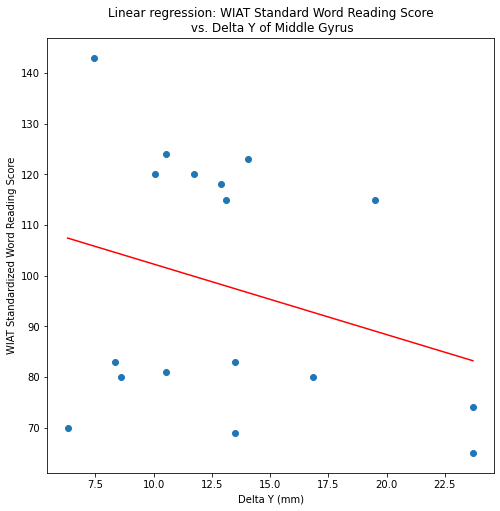

In [318]:
ret = make_regression(df_reg, xname, yname, plot_title, xtitle, ytitle)

## Regression 2

In [320]:
xname = 'DeltaY'
yname = 'word_stnd_num'

df_reg = df_pheno[df_pheno['LCCorr'] == 3][[xname, yname]]

plot_title = 'Linear regression: WIAT Standard Word Reading Score\n vs. Delta Y of Posterior-Most Gyrus'
xtitle = 'Delta Y (mm)'
ytitle = 'WIAT Standardized Word Reading Score'

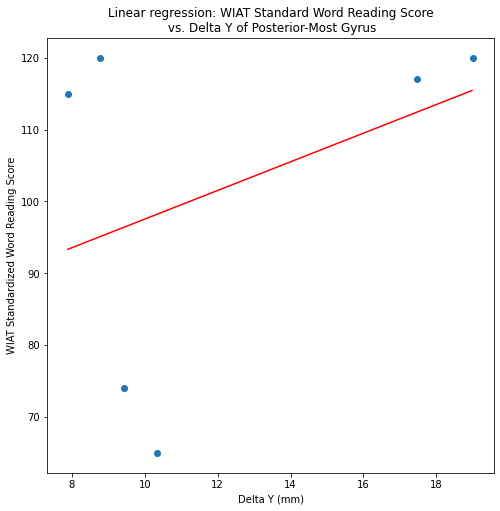

In [321]:
ret2 = make_regression(df_reg, xname, yname, plot_title, xtitle, ytitle)

In [322]:
r2

0.08287387787098444

## Regression 3

In [330]:
xname = 'DeltaY'
yname = 'word_stnd_num'

df_reg = df_pheno[df_pheno['LCCorr'] == 1][[xname, yname]]

plot_title = 'Linear regression: WIAT Standard Word Reading Score\n vs. Delta Y of Anterior-Most Gyrus'
xtitle = 'Delta Y (mm)'
ytitle = 'WIAT Standardized Word Reading Score'

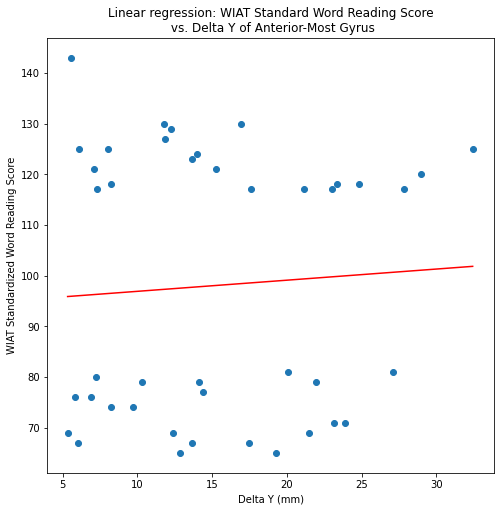

In [331]:
ret3 = make_regression(df_reg, xname, yname, plot_title, xtitle, ytitle)

In [329]:
ret3['r2']

0.004009493190203717

## Regression 4

- Total gap length

In [343]:
df_sum_dy = df_pheno[df_pheno.LCCorr != 0].groupby('EID', as_index=False).sum()[['EID', 'DeltaY']]
df_sum_dy.columns = ['EID', 'SumDeltaY']

In [355]:
df_eid_unq = df_pheno.groupby('EID', as_index=False).mean()
df_eid_unq = pd.merge(df_eid_unq, df_sum_dy, on='EID', how='left')

In [358]:
df_sumreg = df_eid_unq[['SumDeltaY','word_stnd_num']].dropna()

In [359]:
xname = 'SumDeltaY'
yname = 'word_stnd_num'

df_reg = df_sumreg

plot_title = 'Linear regression: WIAT Standard Word Reading Score\n vs. Sum of Delta Y Over All Gyri'
xtitle = 'Sum of Delta Y Over All Gyri (mm)'
ytitle = 'WIAT Standardized Word Reading Score'

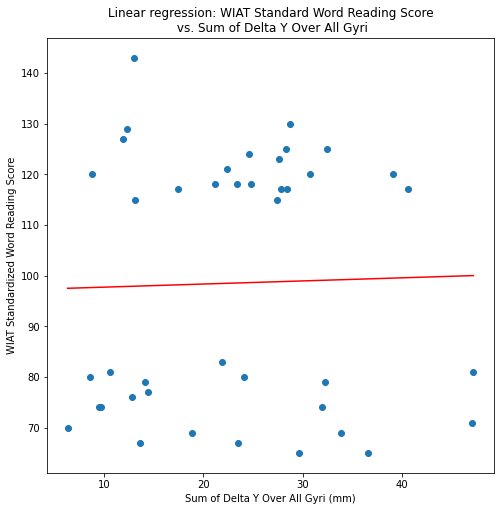

In [360]:
ret4 = make_regression(df_reg, xname, yname, plot_title, xtitle, ytitle)

In [362]:
r2 = ret['r2']
r2, len(df_sumreg)

(0.08287387787098444, 41)

# Bar plots

In [370]:
df_count = df_pheno.groupby('EID', as_index=False).count()[['EID', 'AnatFile']]
df_count.columns = ['EID', 'Count']

In [372]:
df_count['Count'] = df_count['Count'] - 1

In [374]:
df_pheno = pd.merge(df_pheno, df_count, on='EID', how='left')

In [377]:
df_barplot = df_pheno.groupby('EID', as_index=False).mean()

### Bar plot 1

In [382]:
means = df_barplot.groupby('Count', as_index=False)['word_stnd_num'].mean()
stds = df_barplot.groupby('Count', as_index=False)['word_stnd_num'].std()
counts = df_barplot.groupby('Count', as_index=False)['word_stnd_num'].count()

In [383]:
means, stds, counts

(   Count  word_stnd_num
 0    0.0      94.500000
 1    1.0     100.875000
 2    2.0      96.826087
 3    5.0     125.000000,
    Count  word_stnd_num
 0    0.0      28.991378
 1    1.0      23.706188
 2    2.0      26.142359
 3    5.0            NaN,
    Count  word_stnd_num
 0    0.0              2
 1    1.0             16
 2    2.0             23
 3    5.0              1)

In [398]:
hts = np.array(means['word_stnd_num'])[:-1]
errs = np.array(stds['word_stnd_num'])[:-1]

In [402]:
ns = np.array(counts['word_stnd_num'])

In [405]:
std_errs = np.array([e/n for e, n in zip(errs, ns)])

In [406]:
std_errs

array([14.49568901,  1.48163673,  1.1366243 ])

In [391]:
lbs = list(range(3))

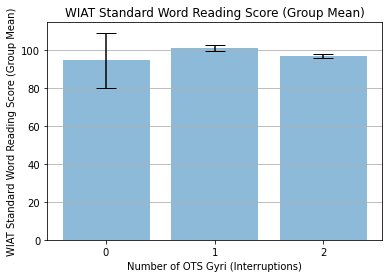

In [407]:
# Build the plot

fig, ax = plt.subplots()
ax.bar(lbs, hts, yerr=std_errs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('WIAT Standard Word Reading Score (Group Mean)')
ax.set_xlabel('Number of OTS Gyri (Interruptions)')
ax.set_xticks(lbs)
ax.set_xticklabels(lbs)
ax.set_title('WIAT Standard Word Reading Score (Group Mean)')
ax.yaxis.grid(True)


In [410]:
gyri_labels = df_pheno[df_pheno.LCCorr!= 0]['LabelObject']

In [ ]:
gyri_labels = 

In [411]:
os.getcwd()

'/Users/samjohns/fsa-data'